# Rank-1 Introduction

# Import packages

### Import python packages

In [1]:
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
import random
from tqdm import trange
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()
os.environ["CUDA_VISIBLE_DEVICES"]="6"

### Import custom packages

In [2]:
from generate import generate
from plot_training import plot_training

# Generate the Dataset

### Set parameters

In [3]:
n1 = 10
n2 = 100
nx = 50
nt = 20
states = np.arange(n1, dtype=float)
nuisances = np.arange(n2, dtype=float)/n2
#states = np.array([3,5,7,11,19,29,61,137,313,503])
#nuisances = np.array([1,2,4,8,16,32,64,128,256,512])


### Generate X

In [4]:
data = generate(states,nuisances,nx,nt,replace=0)
X = data.X
X_states = data.X_states
X_nuisances = data.X_nuisances

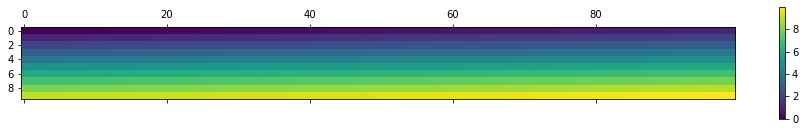

In [5]:
plt.matshow(data.D)
plt.colorbar()

### What blocks in D is selected by X?

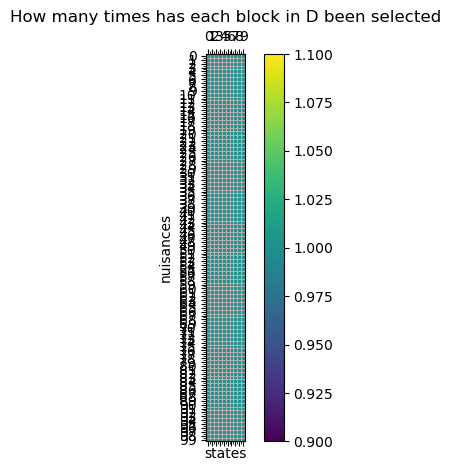

In [6]:
waiting_samples = data.waiting_samples
D_selected = np.ones((n1,n2))
for i in range(n1):
    for j in range(n2):
        D_selected[i][waiting_samples[i]] = 0    
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(data.selected_times.T, fignum=1)
plt.ylabel('nuisances');plt.xlabel('states')
plt.xticks(range(n1));plt.yticks(range(n2))
plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
plt.grid(which='minor')
plt.title('How many times has each block in D been selected')
plt.colorbar()
plt.show()

# Set SymAE

### Set layers

In [7]:
class SymmetricEncoderDense0D(tf.keras.Model):
    def __init__(self, p, w):
        super(SymmetricEncoderDense0D, self).__init__(name='sym_encoder')
        self.d1=tfkl.Dense(w, activation=tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(p)
    def call(self, x, training=False):
        x=self.d1(x)
        x=tf.math.reduce_mean(x,axis=1)
        x=self.d2(x)
        #x=tf.math.floormod(x,n1)
        return x
# 你是在让 nuisance encoder 记住states
class NuisanceEncoderDense0D(tf.keras.Model):
    def __init__(self, q, w):
        super(NuisanceEncoderDense0D, self).__init__(name='nui_encoder')
        self.d1=tfkl.Dense(w, activation=tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(q)
    def call(self, x, training=False):
        x=self.d1(x)
        x=self.d2(x)
        return x
class DistributeZsym(tf.keras.Model):
    def __init__(self, ntau, nz0, nzi):
        super(DistributeZsym, self).__init__(name='dist')
        self.nz0=nz0
        self.nzi=nzi
        self.ntau=ntau
        self.ri=tfkl.Reshape(target_shape=(ntau,nzi))
        self.repeat=tfkl.RepeatVector(ntau)
    def call(self, z, training=False):
        z0,zi=tf.split(z,[self.nz0, self.ntau*self.nzi],axis=1)
        zi=self.ri(zi)
        z0=self.repeat(z0)
        out=tfkl.concatenate([z0, zi],axis=2)
        return out
class MixerDense0D(tf.keras.Model):
    def __init__(self, w):
        super(MixerDense0D, self).__init__(name='mixer')
        self.d1=tfkl.Dense(w, activation=tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(1)
    def call(self, x, training=False):
        x=self.d1(x)
        x=self.d2(x)
        #x=tf.math.reduce_sum(x, axis=-1, keepdims=True)
        return x

In [8]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=1.0):
        super(LatentCat, self).__init__(name='latentcat')
        self.drop = tfkl.Dropout(alpha)
        
    def call(self, zsym, znuisance, mask=1):
        print(znuisance)
        znuisance = znuisance*mask
        print(znuisance)
        
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

### model

In [39]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, p, q, w): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = SymmetricEncoderDense0D(p, w)
        self.sym_encoder=sym_encoder
        # Build nuisance encoder
        nui_encoder = NuisanceEncoderDense0D(q, w)
        self.nui_encoder = nui_encoder
        #Build latentcat
        latentcat = LatentCat()
        self.latentcat = latentcat  
        # Build distribute in decoder
        distzsym = DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        #Build mixer in decoder
        mixer = MixerDense0D(w)
        self.mixer = mixer
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, input_tensor,mask=1, training=False):
        znuisance = self.nui_encoder(input_tensor)
        zsym = self.sym_encoder(input_tensor)
        encoder_output=self.latentcat(zsym,znuisance,mask)
        decoder_output=self.mixer(self.distzsym(encoder_output))
        return decoder_output

### Initialize SymAE

In [41]:
p = 1
q = 2
w = 1000
model = SymAE(nx,nt,p,q,w)
path = './p=%d,q=%d,w=%d'%(p,q,w)
clear_output()

In [42]:
try:
    model.load_weights(path+'/checkpoint')
    print("weight exists")
except:
    print("weight doesn't exist")

weight exists


In [43]:
#model.latentcat.drop.rate = 0.0

### Select optimizer

In [30]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False)
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(loss='mse',optimizer=Adam)
clear_output()

In [31]:
M=10000
epochs=range(M)
losses=[np.nan]*M
redata=[np.nan]*M
sample_size = 10
redatum_list = list(zip(np.random.randint(0,nx,sample_size),np.random.randint(0,nx,sample_size)))

# Train

### From scratch

In [32]:
@tf.function
def redatum(X1, X2):
    return model.decoder(
        model.latentcat(
            model.sym_encoder(X1), 
            model.nui_encoder(X2),
            training=False
        ))
@tf.function
def redatum_loss(X):
    s = []
    for (i1,i2) in redatum_list:
        X1 = X[i1:i1+1]
        X2 = X[i2:i2+1]
        redata = redatum(X1,X2)
        origin = states[X_states[i1]]+nuisances[X_nuisances[i2,:]]
        s.append(mse(redata[0,:,0],origin))
    return sum(s)/sample_size
@tf.function
def reconstruction_loss(model, x, training=False):
    s=0
    s+=mse(x,model(x, mask=[1,1]))
    s+=mse(x,model(x, mask=[1,0]))
    s+=mse(x,model(x, mask=[0,1]))
    return s
@tf.function
def train_step(model, x, training=True):
    with tf.GradientTape() as tape:
        loss_rec = reconstruction_loss(model, x, training)
        loss = loss_rec
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_rec

In [33]:
for epoch in range(10000):
    loss_rec = train_step(model, X)
    losses[epoch]=loss_rec
    redata[epoch]=redatum_loss(X)
    print("For epoch {:d}, reconstruction loss is {:f}."
          .format(epoch, loss_rec))
    print("redatum: %f"%redata[epoch])
    clear_output(wait=True)


KeyboardInterrupt



### Save weights

In [40]:
#model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
model.save_weights(path+'/checkpoint')
print("weights saved")

weights saved


### Loss-epoch graph

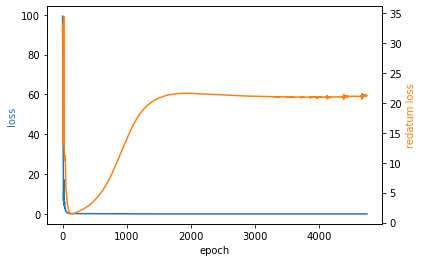

In [35]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(epochs,losses,'C0')
ax2.plot(epochs,redata,'C1')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='C0')
ax2.set_ylabel('redatum loss', color='C1')
plt.savefig(path+'/train.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Visualize training loss

### Creat a dict mapping from subscripts of D to subscripts of X

This map is the inverse of X_states and X_nuisances

In [44]:
subscript_map = {}
for i in range(nx):
    for j in range(nt):
        subscript_map[(X_states[i],X_nuisances[i,j])] = (i,j)

### Plot D and SymAE(X)

Tensor("sym_ae_3/nui_encoder/dense_21/BiasAdd:0", shape=(None, 20, 2), dtype=float32)
Tensor("sym_ae_3/latentcat/mul:0", shape=(None, 20, 2), dtype=float32)
2/2 [==============================] - 0s 5ms/step


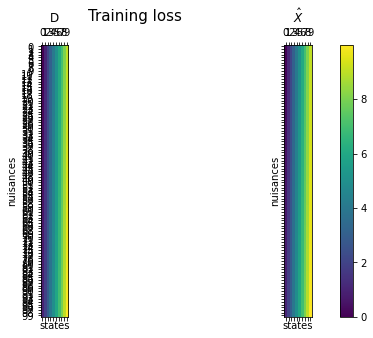

In [45]:
D = data.D
X_hat = model.predict(X)[:,:,0]
X_converted_max = np.empty((n1,n2))
X_converted_max.fill(-np.inf)
X_converted_min = np.empty((n1,n2))
X_converted_min.fill(np.inf)
for i in range(nx):
    for j in range(nt):
        i_D = X_states[i]
        j_D = X_nuisances[i,j]
        X_converted_max[i_D,j_D] = max(X_hat[i,j],X_converted_max[i_D,j_D])
        X_converted_min[i_D,j_D] = min(X_hat[i,j],X_converted_max[i_D,j_D])
def plot_reconstruct(D,X_converted):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
    norm = mcolors.Normalize(vmin=np.amin(D), vmax=np.amax(D))
    pcm = axs[0].matshow(D.T, norm = norm)
    axs[0].set_ylabel('nuisances')
    axs[0].set_xlabel('states')
    axs[0].set_xticks(range(n1))
    axs[0].set_yticks(range(n2))
    axs[0].set_title('D')
    pcm = axs[1].matshow(X_converted.T, norm = norm)
    axs[1].set_ylabel('nuisances')
    axs[1].set_xlabel('states')
    axs[1].set_xticks(range(n1))
    axs[1].set_yticks(range(n2))
    axs[1].set_title('$\hat{X}$')
    fig.colorbar(pcm,ax=axs)
    return fig
fig = plot_reconstruct(D,X_converted_max)
fig.suptitle('Training loss',fontsize=15)
plt.savefig(path+'/train_matrix.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Visualize performance of redatuming

### Evaluate latent code

In [46]:
Cs = model.sym_encoder.predict(X, verbose=0)
Ns = model.nui_encoder.predict(X, verbose=0)
print(Cs.shape); print(Ns.shape)

(50, 1)
(50, 20, 2)


### Creat a dict, mapping from coordinates of missing blocks (in D) to coordinates i, i', j (in X)

In [47]:
missing_map = {}
for i_D in range(n1):
    for j_D in range(n2):
        state_candidates = np.argwhere(X_states==i_D) 
        nuisance_candidates = np.argwhere(X_nuisances==j_D) 
        i_s, = state_candidates[np.random.choice(state_candidates.shape[0])]
        i_n, j_n = nuisance_candidates[np.random.choice(nuisance_candidates.shape[0])]
        missing_map[i_D,j_D] = (i_n,i_s,j_n)
for i_D in range(n1):
    for j_D in range(n2):
        i, i_prime, j = missing_map[i_D,j_D] 
        assert X_states[i_prime] == i_D
        assert X_nuisances[i,j] == j_D

### Fill out X_redatum

In [48]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,0]
X_redatum = np.empty((n1,n2))
coherent_i_prime = np.empty((1,p))
nuisance_i_j = np.empty((1,q*nt))
for (i_D,j_D) in missing_map.keys():
    i,i_prime,j = missing_map[i_D,j_D]
    coherent_i_prime = Cs[i_prime,:]
    nuisance_i_j = Ns[i,j]
    merger = np.concatenate([coherent_i_prime,nuisance_i_j])
    X_redatum[i_D,j_D] = dec(merger)  
    
    X_redatum[i_D,j_D] = redatum(X[i_prime:i_prime+1], X[i:i+1]).numpy()[0,j,0]
clear_output()

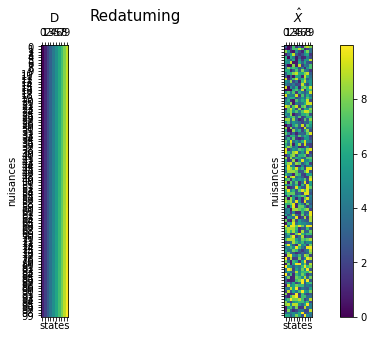

<tf.Tensor: shape=(), dtype=float64, numpy=15.106558993469651>

In [49]:
fig = plot_reconstruct(D,X_redatum)
fig.suptitle('Redatuming',fontsize=15)
plt.savefig(path+'/redatum.pdf', format='pdf', bbox_inches='tight')
plt.show()
mse(D, X_redatum)

# PCA

In [ ]:
C_reshaped = list(map(tuple, np.repeat(Cs, nt, axis=0))) 
N_reshaped = list(map(tuple, Ns.reshape(-1,q)))
state_reshaped = states[np.repeat(X_states, nt, axis=0)]
nuisance_reshaped = nuisances[X_nuisances.reshape(-1,1)[:,0]]
data_dict = {'latent state':C_reshaped,
             'latent nuisance':N_reshaped,
             'true state':state_reshaped,
             'true nuisance':nuisance_reshaped}
C_pca = list(map(tuple,PCA(min(3,p)).fit_transform(C_reshaped)))
N_pca = list(map(tuple,PCA(min(3,q)).fit_transform(N_reshaped)))
data_dict['PCA latent state'] = C_pca
data_dict['PCA latent nuisance'] = N_pca
df = pd.DataFrame(data_dict)
df.shape

### p-space (latent coherent space)

In [ ]:
if p==1:
    df = pd.DataFrame(Cs, columns = ['1st'])
    df = pd.concat([df,pd.DataFrame(X_states,columns=['state'])],axis=1)
    df = pd.concat([df,pd.DataFrame(np.zeros(len(Cs)),columns=['0'])],axis=1)
    fig = px.scatter(df, x='1st',y='0', color='state')
    fig.show()
elif p==2:
    pca = PCA(n_components=2)
    pca_C = pca.fit_transform(Cs)
    df = pd.DataFrame(pca_C, columns = ['1st','2nd'])
    tem = pd.DataFrame(X_states,columns=['state'])
    df = pd.concat([df,tem],axis=1)
    df.sort_values('state',inplace=True)
    fig = px.scatter(df, x='1st', y='2nd', color='state')
    fig.update_layout(title_text='p space PCA')
    fig.show()
elif p>=3:
    pca = PCA(n_components=3)
    pca_C = pca.fit_transform(Cs)
    df = pd.DataFrame(pca_C, columns = ['1st','2nd','3rd'])
    tem = pd.DataFrame(X_states,columns=['state'])
    df = pd.concat([df,tem],axis=1)
    df.sort_values('state',inplace=True)
    fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
    fig.update_layout(title_text='p space PCA')
    fig.show()    
fig.write_image(path+'/latent_C.pdf')


### q space (latent nuisance space)

In [ ]:
pca_N = Ns.reshape(-1,q)
df = pd.DataFrame(pca_N, columns = np.arange(q))
tem = pd.DataFrame(X_nuisances.reshape(-1,1),columns=['nuisance'])
df = pd.concat([df,tem],axis=1)
tem = pd.DataFrame(np.repeat(X_states,nt,axis=0),columns=['state'])
df = pd.concat([df,tem],axis=1)
from plotly.subplots import make_subplots
fig = make_subplots(rows=q, cols=1, 
                    shared_xaxes=True,
                    vertical_spacing=0.01)
for i in trange(q):
    fig.add_trace(
        go.Scatter(x=df['nuisance'], 
                   y=df[i], 
                   marker=dict(color=df['state']),
                   mode='markers'
                  ), 
        row=i+1, col=1
        )
#fig = px.scatter(df, x='nuisance', y=4, color='state')
fig.update_layout(title_text="q-space PCA, x:real nuisance, \
y:latent code, color:state")
#fig.update_traces(textposition='top center')
fig.update_layout(height=q*200, width=600)
fig.update_layout(showlegend=False)
fig.write_image(path+'/latent.pdf')
fig.show()

In [ ]:
# df1 = pd.DataFrame(tf.reshape(model.nui_encoder(X),[-1,q]), columns = ['latent nuisance'])
# df2 = pd.DataFrame(nuisances[X_nuisances.reshape(-1,1)],columns=['nuisance'])
# df3 = pd.DataFrame(np.repeat(states[X_states],nt,axis=0),columns=['state'])
# df4 = pd.DataFrame(np.zeros(df1.shape[0]),columns=['0'])
# df = pd.concat([df1,df2,df3,df4],axis=1)
# fig = px.scatter(df, x='latent nuisance', color='nuisance', y='0')
# fig.update_layout(title="For epoch {:d}, reconstruction loss is {:f}."
#       .format(epoch, loss_rec))
# fig.show()
